In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas

2023-11-08 11:28:56.154764: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 11:28:56.178237: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
train_file = "./train.tsv"
test_file = "./test.tsv"
train_data = pandas.read_csv(train_file, delimiter='\t').to_numpy()#.astype(np.float32)
# train_data[:, 0] = train_data[:, 0].astype(np.float64)
# train_data[:, 2:] = train_data[:, 2:].astype(np.float64)
train_data2 = np.empty((train_data.shape[0], train_data.shape[1]-1))
train_data2[:, 0] = train_data[:, 0].astype(np.float64)
train_data2[:, 1:] = train_data[:, 2:].astype(np.float64)
test_data = pandas.read_csv(test_file, delimiter='\t').to_numpy()#.astype(np.float32)
test_data[:, 0] = test_data[:, 0].astype(np.float32)
test_data[:, 2:] = test_data[:, 2:].astype(np.float32)

display(train_data2)
display(test_data)

x = train_data2[:, 13:]
x = x.reshape(x.shape[0], 1)
print(x)
y = train_data2[:, :13]
y = y.reshape(y.shape[0], y.shape[1], 1)
print(y)

array([[1.000e+00, 1.000e+00, 0.000e+00, ..., 8.100e-01, 0.000e+00,
        1.600e+01],
       [2.000e+00, 1.000e+00, 0.000e+00, ..., 8.000e-01, 0.000e+00,
        4.000e+01],
       [3.000e+00, 1.000e+00, 0.000e+00, ..., 8.000e-01, 0.000e+00,
        3.200e+01],
       ...,
       [8.643e+03, 1.000e+00, 0.000e+00, ..., 5.800e-01, 1.940e-01,
        5.200e+01],
       [8.644e+03, 1.000e+00, 0.000e+00, ..., 6.200e-01, 1.343e-01,
        3.800e+01],
       [8.645e+03, 1.000e+00, 0.000e+00, ..., 6.600e-01, 0.000e+00,
        3.100e+01]])

array([[8646.0, '2012-01-01', 1.0, ..., 0.37880000472068787,
        0.6600000262260437, 0.0],
       [8647.0, '2012-01-01', 1.0, ..., 0.34850001335144043,
        0.6600000262260437, 0.13429999351501465],
       [8648.0, '2012-01-01', 1.0, ..., 0.34850001335144043,
        0.7599999904632568, 0.0],
       ...,
       [17377.0, '2012-12-31', 1.0, ..., 0.25760000944137573,
        0.6000000238418579, 0.16419999301433563],
       [17378.0, '2012-12-31', 1.0, ..., 0.2727000117301941,
        0.5600000023841858, 0.13429999351501465],
       [17379.0, '2012-12-31', 1.0, ..., 0.2727000117301941,
        0.6499999761581421, 0.13429999351501465]], dtype=object)

[[16.]
 [40.]
 [32.]
 ...
 [52.]
 [38.]
 [31.]]
[[[1.000e+00]
  [1.000e+00]
  [0.000e+00]
  ...
  [2.879e-01]
  [8.100e-01]
  [0.000e+00]]

 [[2.000e+00]
  [1.000e+00]
  [0.000e+00]
  ...
  [2.727e-01]
  [8.000e-01]
  [0.000e+00]]

 [[3.000e+00]
  [1.000e+00]
  [0.000e+00]
  ...
  [2.727e-01]
  [8.000e-01]
  [0.000e+00]]

 ...

 [[8.643e+03]
  [1.000e+00]
  [0.000e+00]
  ...
  [4.091e-01]
  [5.800e-01]
  [1.940e-01]]

 [[8.644e+03]
  [1.000e+00]
  [0.000e+00]
  ...
  [3.939e-01]
  [6.200e-01]
  [1.343e-01]]

 [[8.645e+03]
  [1.000e+00]
  [0.000e+00]
  ...
  [3.788e-01]
  [6.600e-01]
  [0.000e+00]]]


In [39]:
length_of_sequence = 13#train_data.shape[0]
#print(length_of_sequence)
in_out_neurons = 1 #入出力ノード数
n_hidden = 300  #隠れ層 -> 数が多い程，学習モデルの複雑さが増加

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)

In [40]:
y.shape

(8645, 13, 1)

In [41]:
ES = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(y, x,
          batch_size=300,
          epochs=100, #100 epochで学習
          validation_split=0.1, #学習データの10%をvalidationに用いる
          callbacks=[ES]
          )

Epoch 1/100


2023-11-08 12:13:36.757378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-11-08 12:13:41.005545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-08 12:13:41.031180: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9ea4225680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-08 12:13:41.031213: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-11-08 12:13:41.067194: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 3/26 [==>...........................] - ETA: 0s - loss: 41671.4219  

2023-11-08 12:13:41.351781: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 [==============================] - 8s 25ms/step - loss: 35579.7930 - val_loss: 20742.6191
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 31777.8047 - val_loss: 19179.9902
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 29923.9824 - val_loss: 17871.8730
Epoch 4/100
26/26 [==============================] - 0s 6ms/step - loss: 28315.3633 - val_loss: 16772.7441
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 26919.3457 - val_loss: 15834.0781
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 25685.9668 - val_loss: 15049.5557
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 24619.5508 - val_loss: 14373.3594
Epoch 8/100
26/26 [==============================] - 0s 5ms/step - loss: 23674.1289 - val_loss: 13807.4844
Epoch 9/100
26/26 [==============================] - 0s 5ms/step - loss: 22843.8750 - val_loss: 13337.9727
Epoch 10/100
26/26 [============================

In [42]:
predicted = model.predict(y)

271/271 [==============================] - 1s 2ms/step


In [43]:
predicted

array([[145.32445],
       [145.32504],
       [145.32523],
       ...,
       [145.32547],
       [145.32547],
       [145.32544]], dtype=float32)

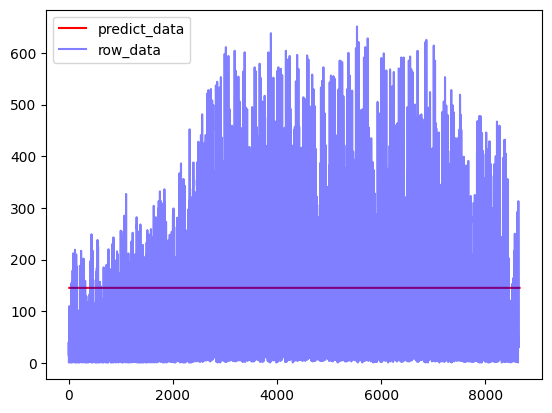

In [46]:
plt.figure()
plt.plot(range(13,len(predicted)+13),predicted, color="r", label="predict_data")
plt.plot(range(0, len(x)), x, color="b", label="row_data", alpha=0.5)
plt.legend()
plt.show()